### Imports

In [1]:
import pandas as pd
import numpy as np

#Python Standard Libs Imports
import json
import urllib2
import sys
from datetime import datetime
from os.path import isfile, join, splitext
from glob import glob

#Imports to enable visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Functions

#### Basic Functions

#### OTP Functions

#### Analysis Functions

### Main Code

#### Reading itinerary alternatives data

In [7]:
all_itineraries = pd.read_csv('/local/tarciso/data/trips-optimality-exp/single-day-test/2017_05_08/itineraries/2017_05_08_itinerary.csv', parse_dates=['planned_start_time','actual_start_time','exec_start_time'])

In [8]:
all_itineraries.head()

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,exec_duration_mins,planned_start_time,actual_start_time,exec_start_time
0,2017-05-08,17179869196,0,23.333333,16.016667,16.016667,2017-05-08 08:08:00,2017-05-08 07:59:32,2017-05-08 07:59:32
1,2017-05-08,17179869196,1,23.700000,23.583333,16.016667,2017-05-08 08:08:00,2017-05-08 08:13:34,2017-05-08 07:59:32
2,2017-05-08,17179869196,3,24.633333,21.366667,16.016667,2017-05-08 08:27:00,2017-05-08 08:24:13,2017-05-08 07:59:32
3,2017-05-08,94489280525,0,22.216667,19.833333,19.833333,2017-05-08 18:28:00,2017-05-08 18:04:31,2017-05-08 18:04:31
4,2017-05-08,94489280525,1,22.350000,20.266667,19.833333,2017-05-08 18:28:00,2017-05-08 18:31:40,2017-05-08 18:04:31


In [9]:
all_itineraries.dtypes

date                             object
user_trip_id                      int64
itinerary_id                      int64
planned_duration_mins           float64
actual_duration_mins            float64
exec_duration_mins              float64
planned_start_time       datetime64[ns]
actual_start_time        datetime64[ns]
exec_start_time          datetime64[ns]
dtype: object

In [10]:
len(all_itineraries)

176

In [11]:
len(all_itineraries.user_trip_id.unique())

50

#### Filtering trips for whose executed itineraries there is no schedule information

In [12]:
def filter_trips_alternatives(trips_alternatives):
    min_trip_dur = 10
    max_trip_dur = 50
    max_trip_start_diff = 20
    
    return trips_alternatives[(trips_alternatives['actual_duration_mins'] >= min_trip_dur) & (trips_alternatives['actual_duration_mins'] <= max_trip_dur)] \
                                    .assign(start_diff = lambda x: np.absolute(x['exec_start_time'] - x['actual_start_time'])/pd.Timedelta(minutes=1)) \
                                    #[lambda x: x['start_diff'] <= 60]

In [13]:
def filter_trips_with_insufficient_alternatives(trips_alternatives):
    num_trips_alternatives = trips_alternatives.groupby(['date','user_trip_id']).size().reset_index(name='num_alternatives')
    trips_with_executed_alternative = trips_alternatives[trips_alternatives['itinerary_id'] == 0][['date','user_trip_id']]
    
    return trips_alternatives.merge(trips_with_executed_alternative, on=['date','user_trip_id'], how='inner') \
                .merge(num_trips_alternatives, on=['date','user_trip_id'], how='inner') \
                [lambda x: x['num_alternatives'] > 1] \
                .sort_values(['user_trip_id','itinerary_id'])   

In [19]:
clean_itineraries = filter_trips_with_insufficient_alternatives(filter_trips_alternatives(all_itineraries))

In [20]:
clean_itineraries.head()

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,exec_duration_mins,planned_start_time,actual_start_time,exec_start_time,start_diff,num_alternatives
0,2017-05-08,17179869196,0,23.333333,16.016667,16.016667,2017-05-08 08:08:00,2017-05-08 07:59:32,2017-05-08 07:59:32,0.000000,3
1,2017-05-08,17179869196,1,23.700000,23.583333,16.016667,2017-05-08 08:08:00,2017-05-08 08:13:34,2017-05-08 07:59:32,14.033333,3
2,2017-05-08,17179869196,3,24.633333,21.366667,16.016667,2017-05-08 08:27:00,2017-05-08 08:24:13,2017-05-08 07:59:32,24.683333,3
3,2017-05-08,94489280525,0,22.216667,19.833333,19.833333,2017-05-08 18:28:00,2017-05-08 18:04:31,2017-05-08 18:04:31,0.000000,4
4,2017-05-08,94489280525,1,22.350000,20.266667,19.833333,2017-05-08 18:28:00,2017-05-08 18:31:40,2017-05-08 18:04:31,27.150000,4


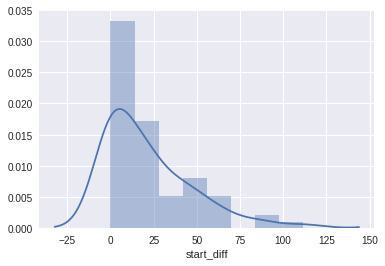

In [21]:
sns.distplot(clean_itineraries['start_diff'])

In [22]:
len(clean_itineraries)

71

In [23]:
len(clean_itineraries.user_trip_id.unique())

20

In [24]:
exec_itineraries_with_scheduled_info = all_itineraries[(all_itineraries['itinerary_id'] == 0) & (pd.notnull(all_itineraries['planned_duration_mins']))][['user_trip_id']]

In [25]:
exec_itineraries_with_scheduled_info.head()

,user_trip_id
0,17179869196
3,94489280525
10,163208757264
24,481036337161
28,506806140942


In [26]:
clean_itineraries2 = filter_trips_with_insufficient_alternatives(filter_trips_alternatives(all_itineraries.merge(exec_itineraries_with_scheduled_info, on='user_trip_id', how='inner')))

In [27]:
clean_itineraries2.head()

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,exec_duration_mins,planned_start_time,actual_start_time,exec_start_time,start_diff,num_alternatives
0,2017-05-08,17179869196,0,23.333333,16.016667,16.016667,2017-05-08 08:08:00,2017-05-08 07:59:32,2017-05-08 07:59:32,0.000000,3
1,2017-05-08,17179869196,1,23.700000,23.583333,16.016667,2017-05-08 08:08:00,2017-05-08 08:13:34,2017-05-08 07:59:32,14.033333,3
2,2017-05-08,17179869196,3,24.633333,21.366667,16.016667,2017-05-08 08:27:00,2017-05-08 08:24:13,2017-05-08 07:59:32,24.683333,3
3,2017-05-08,94489280525,0,22.216667,19.833333,19.833333,2017-05-08 18:28:00,2017-05-08 18:04:31,2017-05-08 18:04:31,0.000000,4
4,2017-05-08,94489280525,1,22.350000,20.266667,19.833333,2017-05-08 18:28:00,2017-05-08 18:31:40,2017-05-08 18:04:31,27.150000,4


In [28]:
len(clean_itineraries2)

51

In [29]:
len(clean_itineraries2.user_trip_id.unique())

14

### Compute Inefficiency Metrics

![title](img/math_model.png)

In [46]:
def select_best_itineraries(trips_itineraries,metric_name):
    return trips_itineraries.sort_values([metric_name]) \
                        .groupby(['date','user_trip_id']) \
                        .nth(0) \
                        .reset_index()

#### Observed Inefficiency

In [47]:
#Choose best itinerary for each trip by selecting the ones with lower actual duration
best_trips_itineraries = select_best_itineraries(clean_itineraries,'actual_duration_mins')

In [51]:
best_trips_itineraries.head()

,date,user_trip_id,actual_duration_mins,actual_start_time,exec_duration_mins,exec_start_time,itinerary_id,num_alternatives,planned_duration_mins,planned_start_time,start_diff
0,2017-05-08,17179869196,16.016667,2017-05-08 07:59:32,16.016667,2017-05-08 07:59:32,0,3,23.333333,2017-05-08 08:08:00,0.000000
1,2017-05-08,94489280525,19.200000,2017-05-08 18:54:24,19.833333,2017-05-08 18:04:31,3,4,27.166667,2017-05-08 18:52:00,49.883333
2,2017-05-08,481036337161,20.683333,2017-05-08 07:29:30,24.850000,2017-05-08 07:07:10,2,4,21.683333,2017-05-08 07:30:30,22.333333
3,2017-05-08,532575944713,24.333333,2017-05-08 06:42:35,25.400000,2017-05-08 06:22:25,3,4,26.416667,2017-05-08 06:44:23,20.166667
4,2017-05-08,670014898190,10.683333,2017-05-08 08:25:16,12.750000,2017-05-08 06:58:30,3,4,15.250000,2017-05-08 08:23:01,86.766667


In [54]:
trips_inefficiency = best_trips_itineraries \
                        .assign(dur_diff = lambda x: x['exec_duration_mins'] - x['actual_duration_mins']) \
                        .assign(observed_inef = lambda x: x['dur_diff']/x['exec_duration_mins'])

In [55]:
trips_inefficiency.head(10)

,date,user_trip_id,actual_duration_mins,actual_start_time,exec_duration_mins,exec_start_time,itinerary_id,num_alternatives,planned_duration_mins,planned_start_time,start_diff,dur_diff,observed_inef
0,2017-05-08,17179869196,16.016667,2017-05-08 07:59:32,16.016667,2017-05-08 07:59:32,0,3,23.333333,2017-05-08 08:08:00,0.000000,0.000000,0.000000
1,2017-05-08,94489280525,19.200000,2017-05-08 18:54:24,19.833333,2017-05-08 18:04:31,3,4,27.166667,2017-05-08 18:52:00,49.883333,0.633333,0.031933
2,2017-05-08,481036337161,20.683333,2017-05-08 07:29:30,24.850000,2017-05-08 07:07:10,2,4,21.683333,2017-05-08 07:30:30,22.333333,4.166667,0.167673
3,2017-05-08,532575944713,24.333333,2017-05-08 06:42:35,25.400000,2017-05-08 06:22:25,3,4,26.416667,2017-05-08 06:44:23,20.166667,1.066667,0.041995
4,2017-05-08,670014898190,10.683333,2017-05-08 08:25:16,12.750000,2017-05-08 06:58:30,3,4,15.250000,2017-05-08 08:23:01,86.766667,2.066667,0.162092
5,2017-05-08,755914244105,10.966667,2017-05-08 19:31:45,10.966667,2017-05-08 19:31:45,0,4,10.033333,2017-05-08 19:56:00,0.000000,0.000000,0.000000
6,2017-05-08,816043786247,10.033333,2017-05-08 06:29:24,18.150000,2017-05-08 06:09:22,2,4,14.750000,2017-05-08 06:32:36,20.033333,8.116667,0.447199
7,2017-05-08,850403524623,16.416667,2017-05-08 08:00:38,46.916667,2017-05-08 07:01:56,3,4,19.383333,2017-05-08 07:57:45,58.700000,30.500000,0.650089
8,2017-05-08,867583393795,11.433333,2017-05-08 07:59:55,32.766667,2017-05-08 07:19:00,3,4,16.166667,2017-05-08 08:00:12,40.916667,21.333333,0.651068
9,2017-05-08,936302870530,10.850000,2017-05-08 07:59:41,13.383333,2017-05-08 07:51:35,1,4,15.400000,2017-05-08 07:55:56,8.100000,2.533333,0.189290


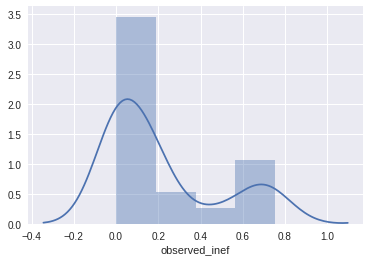

In [57]:
sns.distplot(trips_inefficiency.observed_inef)

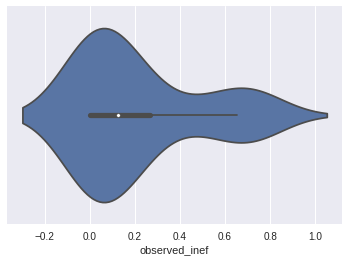

In [58]:
sns.violinplot(trips_inefficiency.observed_inef)

In [59]:
pos_trips_inefficiency = trips_inefficiency[trips_inefficiency['observed_inef'] > 0]

In [60]:
pos_trips_inefficiency.head()

,date,user_trip_id,actual_duration_mins,actual_start_time,exec_duration_mins,exec_start_time,itinerary_id,num_alternatives,planned_duration_mins,planned_start_time,start_diff,dur_diff,observed_inef
1,2017-05-08,94489280525,19.200000,2017-05-08 18:54:24,19.833333,2017-05-08 18:04:31,3,4,27.166667,2017-05-08 18:52:00,49.883333,0.633333,0.031933
2,2017-05-08,481036337161,20.683333,2017-05-08 07:29:30,24.850000,2017-05-08 07:07:10,2,4,21.683333,2017-05-08 07:30:30,22.333333,4.166667,0.167673
3,2017-05-08,532575944713,24.333333,2017-05-08 06:42:35,25.400000,2017-05-08 06:22:25,3,4,26.416667,2017-05-08 06:44:23,20.166667,1.066667,0.041995
4,2017-05-08,670014898190,10.683333,2017-05-08 08:25:16,12.750000,2017-05-08 06:58:30,3,4,15.250000,2017-05-08 08:23:01,86.766667,2.066667,0.162092
6,2017-05-08,816043786247,10.033333,2017-05-08 06:29:24,18.150000,2017-05-08 06:09:22,2,4,14.750000,2017-05-08 06:32:36,20.033333,8.116667,0.447199


#### Schedule Inefficiency

In [70]:
shortest_planned_itineraries = select_best_itineraries(clean_itineraries[pd.notnull(clean_itineraries['planned_duration_mins'])],'planned_duration_mins') \
                            [['date','user_trip_id','planned_duration_mins','actual_duration_mins']] \
                            .rename(index=str,columns={'planned_duration_mins':'shortest_scheduled_planned_duration',
                                               'actual_duration_mins':'shortest_scheduled_observed_duration'})

shortest_planned_itineraries.head()

,date,user_trip_id,shortest_scheduled_planned_duration,shortest_scheduled_observed_duration
0,2017-05-08,17179869196,23.333333,16.016667
1,2017-05-08,94489280525,22.216667,19.833333
2,2017-05-08,481036337161,21.500000,24.850000
3,2017-05-08,532575944713,25.766667,24.500000
4,2017-05-08,670014898190,15.016667,12.750000


In [90]:
rec_inef_i = best_trips_itineraries \
                .rename(index=str,columns={'actual_duration_mins','shortest_observed_duration'}) \
                .merge(shortest_planned_itineraries, on=['date','user_trip_id'], how='inner') \
                [['date','user_trip_id','shortest_observed_duration','shortest_scheduled_observed_duration']] \
                .assign(rec_inef = lambda x: (x['shortest_scheduled_observed_duration'] - x['shortest_observed_duration'])/x['shortest_scheduled_observed_duration'])

rec_inef_i.head()

TypeError: 'set' object is not callable

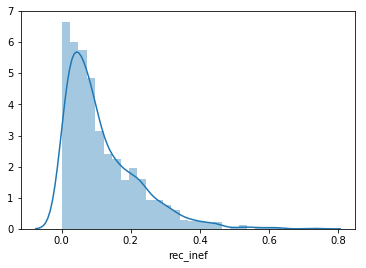

In [60]:
sns.distplot(rec_inef_i[rec_inef_i['rec_inef'] > 0].rec_inef)

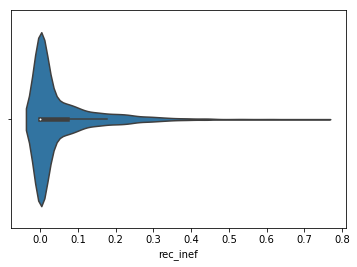

In [61]:
sns.violinplot(rec_inef_i.rec_inef)

#### User choice plan inefficiency

In [73]:
best_scheduled_itineraries = select_best_itineraries(clean_itineraries2,'planned_duration_mins') \
                                [['date','user_trip_id','planned_duration_mins']] \
                                .rename(index=str,columns={'planned_duration_mins':'best_planned_duration_mins'})

In [75]:
best_scheduled_itineraries.head()

,date,user_trip_id,best_planned_duration_mins
0,2017-05-08,17179869196,23.333333
1,2017-05-08,94489280525,22.216667
2,2017-05-08,481036337161,21.500000
3,2017-05-08,670014898190,15.016667
4,2017-05-08,755914244105,10.033333


In [78]:
plan_inef = clean_itineraries2.merge(best_scheduled_itineraries, on=['date','user_trip_id'], how='inner') \
                [lambda x: x['itinerary_id'] == 0] \
                [['date','user_trip_id','planned_duration_mins','best_planned_duration_mins']] \
                .assign(plan_inef = lambda x: (x['planned_duration_mins'] - x['best_planned_duration_mins'])/(x['planned_duration_mins']))

In [80]:
plan_inef.head()

,date,user_trip_id,planned_duration_mins,best_planned_duration_mins,plan_inef
0,2017-05-08,17179869196,23.333333,23.333333,0.0
3,2017-05-08,94489280525,22.216667,22.216667,0.0
7,2017-05-08,481036337161,21.500000,21.500000,0.0
11,2017-05-08,670014898190,15.016667,15.016667,0.0
15,2017-05-08,755914244105,10.033333,10.033333,0.0


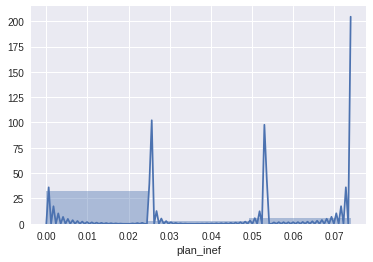

In [82]:
sns.distplot(plan_inef.plan_inef)

#### System Schedule Deviation
$$
\begin{equation*}
    {Oe - Op}
\end{equation*}
$$

In [84]:
sched_deviation = clean_itineraries[clean_itineraries['itinerary_id'] > 0] \
                    .assign(sched_dev = lambda x: x['actual_duration_mins'] - x['planned_duration_mins'])
    
sched_deviation.head()

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,exec_duration_mins,planned_start_time,actual_start_time,exec_start_time,start_diff,num_alternatives,sched_dev
1,2017-05-08,17179869196,1,23.700000,23.583333,16.016667,2017-05-08 08:08:00,2017-05-08 08:13:34,2017-05-08 07:59:32,14.033333,3,-0.116667
2,2017-05-08,17179869196,3,24.633333,21.366667,16.016667,2017-05-08 08:27:00,2017-05-08 08:24:13,2017-05-08 07:59:32,24.683333,3,-3.266667
4,2017-05-08,94489280525,1,22.350000,20.266667,19.833333,2017-05-08 18:28:00,2017-05-08 18:31:40,2017-05-08 18:04:31,27.150000,4,-2.083333
5,2017-05-08,94489280525,2,32.300000,30.150000,19.833333,2017-05-08 18:32:24,2017-05-08 18:36:47,2017-05-08 18:04:31,32.266667,4,-2.150000
6,2017-05-08,94489280525,3,27.166667,19.200000,19.833333,2017-05-08 18:52:00,2017-05-08 18:54:24,2017-05-08 18:04:31,49.883333,4,-7.966667


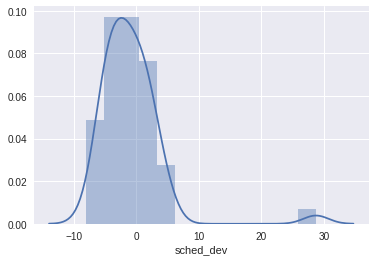

In [85]:
sns.distplot(sched_deviation.sched_dev)

#### User stop waiting time offset
$$
\begin{equation*}
    {start(Oe) - start(Op)}
\end{equation*}
$$

In [87]:
user_boarding_timediff = clean_itineraries[clean_itineraries['itinerary_id'] > 0] \
                    .assign(boarding_timediff = lambda x: (x['actual_start_time'] - x['planned_start_time'])/pd.Timedelta(minutes=1))
    
user_boarding_timediff.head()

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,exec_duration_mins,planned_start_time,actual_start_time,exec_start_time,start_diff,num_alternatives,boarding_timediff
1,2017-05-08,17179869196,1,23.700000,23.583333,16.016667,2017-05-08 08:08:00,2017-05-08 08:13:34,2017-05-08 07:59:32,14.033333,3,5.566667
2,2017-05-08,17179869196,3,24.633333,21.366667,16.016667,2017-05-08 08:27:00,2017-05-08 08:24:13,2017-05-08 07:59:32,24.683333,3,-2.783333
4,2017-05-08,94489280525,1,22.350000,20.266667,19.833333,2017-05-08 18:28:00,2017-05-08 18:31:40,2017-05-08 18:04:31,27.150000,4,3.666667
5,2017-05-08,94489280525,2,32.300000,30.150000,19.833333,2017-05-08 18:32:24,2017-05-08 18:36:47,2017-05-08 18:04:31,32.266667,4,4.383333
6,2017-05-08,94489280525,3,27.166667,19.200000,19.833333,2017-05-08 18:52:00,2017-05-08 18:54:24,2017-05-08 18:04:31,49.883333,4,2.400000


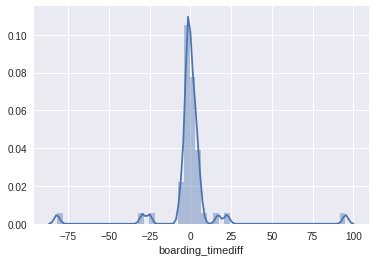

In [88]:
sns.distplot(user_boarding_timediff.boarding_timediff)

#### Adding metadata for further analysis

In [80]:
def get_trip_len_bucket(trip_duration):
    if (trip_duration < 10):
        return '<10'
    elif (trip_duration < 20):
        return '10-20'
    elif (trip_duration < 30):
        return '20-30'
    elif (trip_duration < 40):
        return '30-40'
    elif (trip_duration < 50):
        return '40-50'
    elif (trip_duration >= 50):
        return '50+'
    else:
        return 'NA'


clean_itineraries = clean_itineraries.withColumn('trip_length_bucket',get_trip_len_bucket(F.col('exec_duration_mins')))

ValueError: Cannot convert column into bool: please use '&' for 'and', '|' for 'or', '~' for 'not' when building DataFrame boolean expressions.